<a href="https://colab.research.google.com/github/tarikyazo/retail_demand_analysis/blob/main/Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import pandas as pd

# Load dataset
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [ ]:
# Select features & drop missing values
X = penguins[["bill_length_mm", "bill_depth_mm"]].dropna()

# Quick sanity check
X.describe()

,bill_length_mm,bill_depth_mm
count,342.000000,342.000000
mean,43.921930,17.151170
std,5.459584,1.974793
min,32.100000,13.100000
25%,39.225000,15.600000
50%,44.450000,17.300000
75%,48.500000,18.700000
max,59.600000,21.500000


# KMeans

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Attach to a DataFrame for plotting/inspection
plot_df = X.copy()
plot_df["Cluster"] = clusters
plot_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,Cluster
0,39.1,18.7,181.0,2
1,39.5,17.4,186.0,2
2,40.3,18.0,195.0,2
4,36.7,19.3,193.0,2
5,39.3,20.6,190.0,2


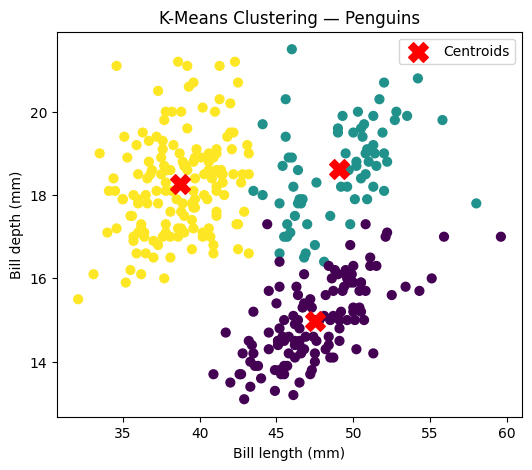

In [ ]:
import matplotlib.pyplot as plt


def plot_clusters(plot_df, kmeans, scaler):
    plt.figure(figsize=(6,5))
    plt.scatter(
        plot_df["bill_length_mm"],
        plot_df["bill_depth_mm"],
        c=plot_df["Cluster"],
        cmap="viridis",
        s=40
    )
    # Plot centroids (unscale back to original space)
    centroids_scaled = kmeans.cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    plt.scatter(
        centroids_unscaled[:, 0],
        centroids_unscaled[:, 1],
        c="red",
        s=200,
        marker="X",
        label="Centroids"
    )
    plt.xlabel("Bill length (mm)")
    plt.ylabel("Bill depth (mm)")
    plt.title("K-Means Clustering — Penguins")
    plt.legend()
    plt.show()

plot_clusters(plot_df, kmeans, scaler)

In [ ]:
print("Inertia:", kmeans.inertia_)

Inertia: 270.1455212611094


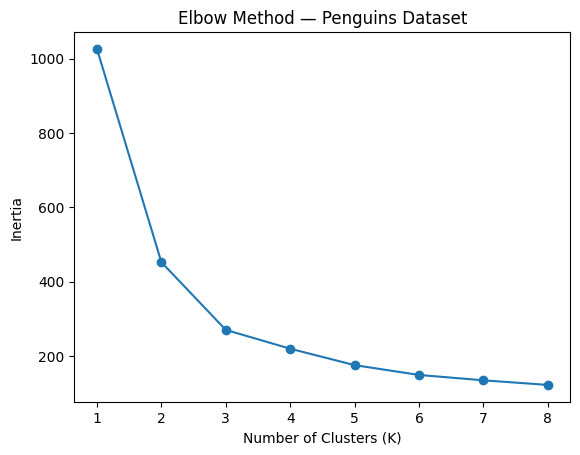

In [ ]:
# After scaling the data

# Try different K values
inertias = []
K_range = range(1, 9)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

def plot_elbow(K_range, inertias):
	# Plot Elbow Curve
	plt.plot(K_range, inertias, marker="o")
	plt.xlabel("Number of Clusters (K)")
	plt.ylabel("Inertia")
	plt.title("Elbow Method — Penguins Dataset")
	plt.show()

plot_elbow(K_range, inertias)

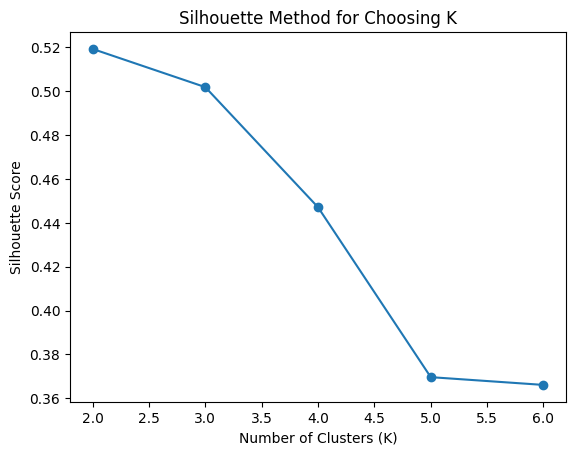

In [ ]:
from sklearn.metrics import silhouette_score

# Try different values of K (must start at 2 for silhouette score)
K = range(2, 7)  # 2 to 6 clusters
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

def plot_silhouette(K, silhouette_scores):
	# Plot silhouette score vs K
	plt.plot(list(K), silhouette_scores, marker="o")
	plt.xlabel("Number of Clusters (K)")
	plt.ylabel("Silhouette Score")
	plt.title("Silhouette Method for Choosing K")
	plt.show()

plot_silhouette(K, silhouette_scores)

# Hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Select numerical features
X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]]

# Standardize features (important for distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels = hc.fit_predict(X_scaled)

# Assign clusters back to penguins
penguins["cluster"] = labels

# Compare clusters with species
print(penguins.groupby(["cluster", "species"]).size())


cluster  species  
0        Gentoo       119
1        Adelie       146
         Chinstrap     11
2        Chinstrap     57
dtype: int64


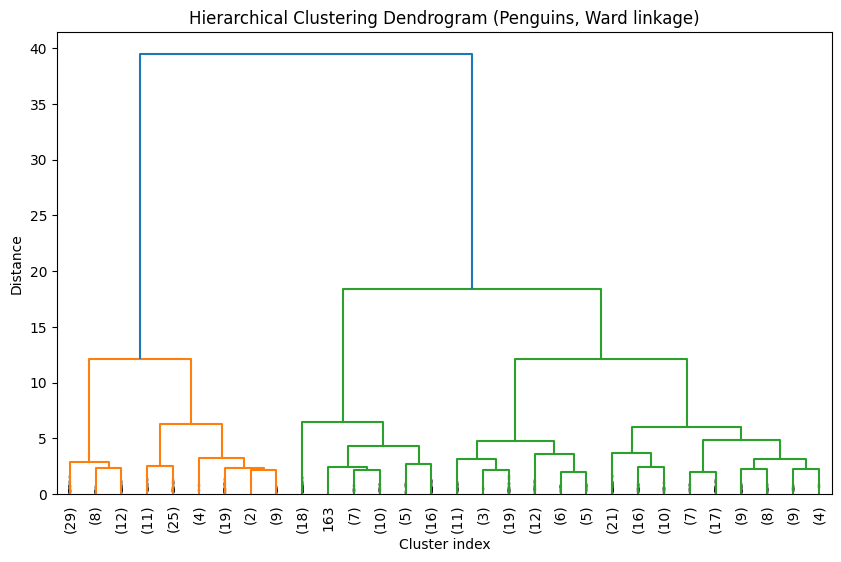

species     Adelie  Chinstrap  Gentoo
hc_cluster                           
1                0          0     119
2                0         57       0
3              146         11       0


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Compute linkage matrix
Z = linkage(X_scaled, method="ward")

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode="lastp",  # show only last merges for readability
    p=30,                   # adjust number of leaf clusters shown
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.title("Hierarchical Clustering Dendrogram (Penguins, Ward linkage)")
plt.xlabel("Cluster index")
plt.ylabel("Distance")
plt.show()

# 5) Cut the tree to get 3 clusters
labels_k3 = fcluster(Z, t=3, criterion="maxclust")

# Add cluster labels to dataframe
penguins["hc_cluster"] = labels_k3

# Compare with actual species
print(pd.crosstab(penguins["hc_cluster"], penguins["species"]))

# DBSCAN

   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  Cluster
0            39.1           18.7              181.0       3750.0        0
1            39.5           17.4              186.0       3800.0        0
2            40.3           18.0              195.0       3250.0        0
4            36.7           19.3              193.0       3450.0        0
5            39.3           20.6              190.0       3650.0        0


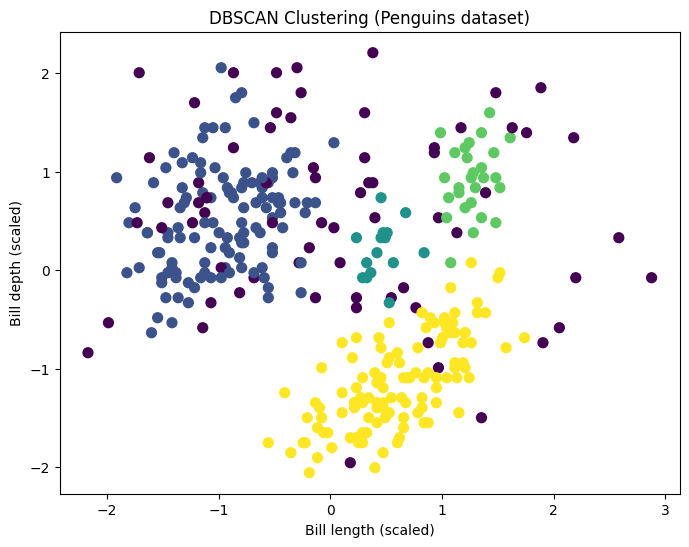

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(X_scaled)

# Add cluster labels to dataframe
X["Cluster"] = labels
print(X.head())

# Plot clusters (first 2 features only for visualization)
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap="viridis", s=50)
plt.title("DBSCAN Clustering (Penguins dataset)")
plt.xlabel("Bill length (scaled)")
plt.ylabel("Bill depth (scaled)")
plt.show()


# K-Means Clustering: End to End Practice

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [ ]:
# Load Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

In [ ]:
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [ ]:
# Creating the dataframe for the scaled data
scaled_df = pd.DataFrame(X_scaled, columns=iris.feature_names)
# looking at the head of it
print(scaled_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0          -0.900681          1.019004          -1.340227         -1.315444
1          -1.143017         -0.131979          -1.340227         -1.315444
2          -1.385353          0.328414          -1.397064         -1.315444
3          -1.506521          0.098217          -1.283389         -1.315444
4          -1.021849          1.249201          -1.340227         -1.315444


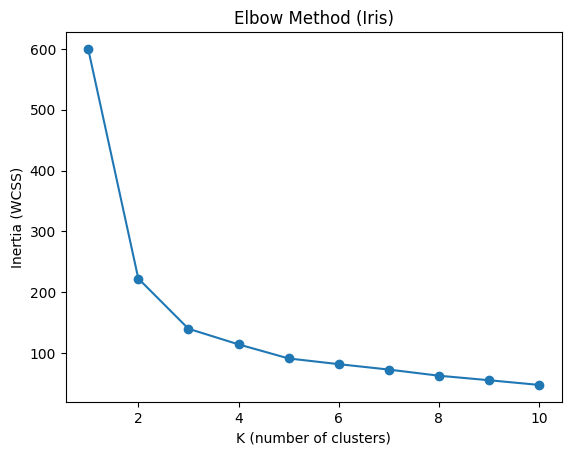

In [ ]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("K (number of clusters)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method (Iris)")
plt.show()

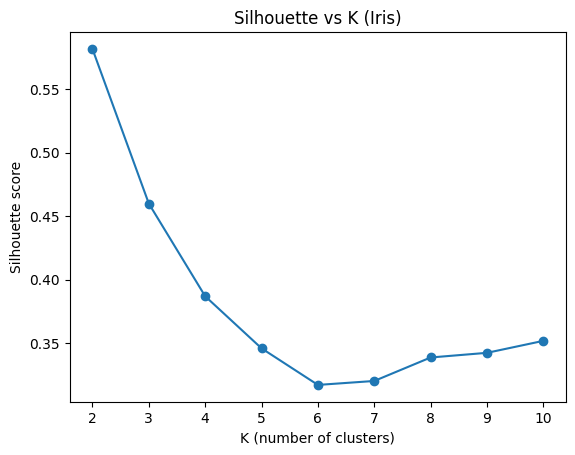

Best K by silhouette: 2


In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 11)  # silhouette needs at least K=2

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("K (number of clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs K (Iris)")
plt.show()

best_k = list(K_range)[int(np.argmax(sil_scores))]
print("Best K by silhouette:", best_k)


In [ ]:
from sklearn.cluster import KMeans

# Create KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3)

In [ ]:
# Fit the model to the data
kmeans.fit(X_scaled)

KMeans(n_clusters=3)

In [ ]:
# Get the cluster labels
df['Cluster'] = kmeans.labels_

In [ ]:
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   Cluster  
0        1  
1        1  
2        1  
3        1  
4        1  


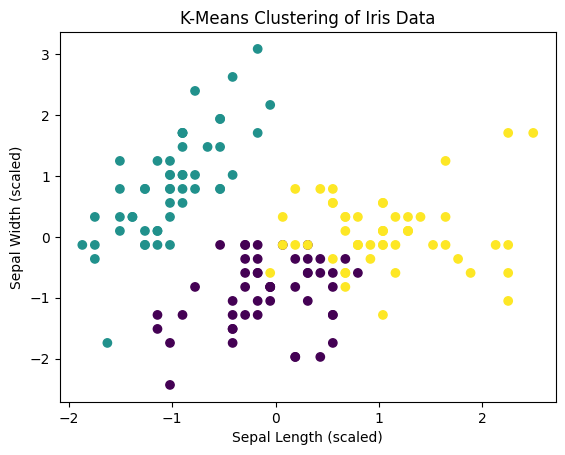

In [ ]:
# Plot the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('Sepal Length (scaled)')
plt.ylabel('Sepal Width (scaled)')
plt.title('K-Means Clustering of Iris Data')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(X_scaled, df['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.45663380641237455


# Anomaly Detection

## End to end isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

# Load the Breast Cancer dataset
data = load_breast_cancer()
X = data.data

# Check the shape of the data
print(X.shape)  # Output: (569, 30)

(569, 30)


In [ ]:
# Initialize Isolation Forest with 100 trees and contamination set to 0.1
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the dataset
iso_forest.fit(X)

IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Get anomaly predictions
predictions = iso_forest.predict(X)

# Extract anomalies and normal points
anomalies = X[predictions == -1]
normal_points = X[predictions == 1]

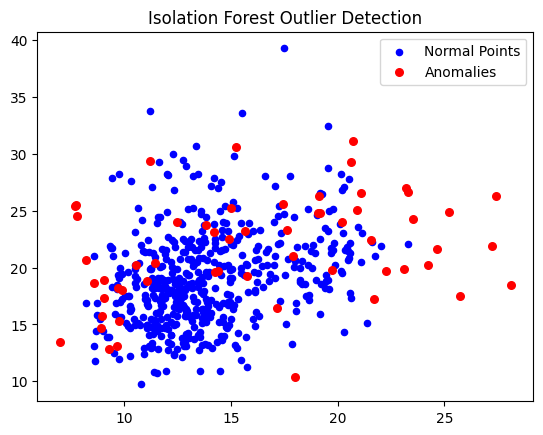

In [ ]:
# Plot anomalies vs normal points using the first two features
plt.scatter(normal_points[:, 0], normal_points[:, 1], label="Normal Points", c='blue', s=20)
plt.scatter(anomalies[:, 0], anomalies[:, 1], label="Anomalies", c='red', s=30)
plt.title("Isolation Forest Outlier Detection")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Simulate true labels: 0 for normal, 1 for anomalies
true_labels = np.zeros(len(X))
# Randomly assign 10% of the samples as anomalies (1s)
anomaly_indices = np.random.choice(len(X), size=int(len(X) * 0.1), replace=False)
true_labels[anomaly_indices] = 1

In [ ]:
from sklearn.metrics import f1_score

# Adjust predictions for comparison with true labels
adjusted_predictions = np.where(predictions == -1, 1, 0)

# Calculate the F1 score
f1 = f1_score(true_labels, adjusted_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.0531


In [ ]:
# Try increasing the number of estimators for potentially better performance
iso_forest = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)
iso_forest.fit(X)

IsolationForest(contamination=0.1, n_estimators=200, random_state=42)

In [ ]:
# Adjust the contamination rate if you expect a different proportion of outliers
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X)

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
# Try limiting the number of features used for each split
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, max_features=10, random_state=42)
iso_forest.fit(X)

IsolationForest(contamination=0.1, max_features=10, random_state=42)

# Dimensionality Reduction

## PCA

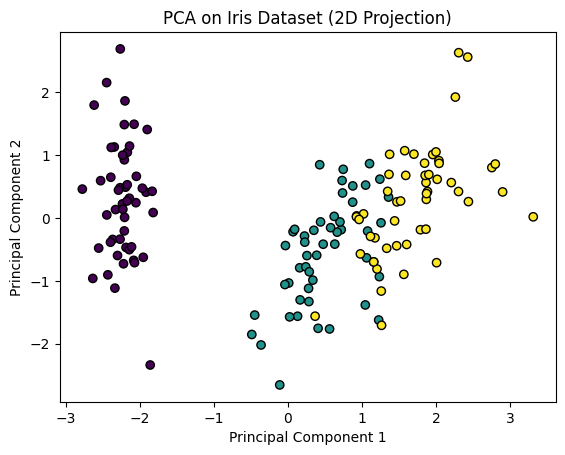

Explained variance ratio: [0.72962445 0.22850762]
Total variance explained: 0.9581320720000166


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Load dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target  # species labels for visualization

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA (reduce to 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Visualize clusters in 2D PCA space
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA on Iris Dataset (2D Projection)")
plt.show()

# 5. Check explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

## t-SNE

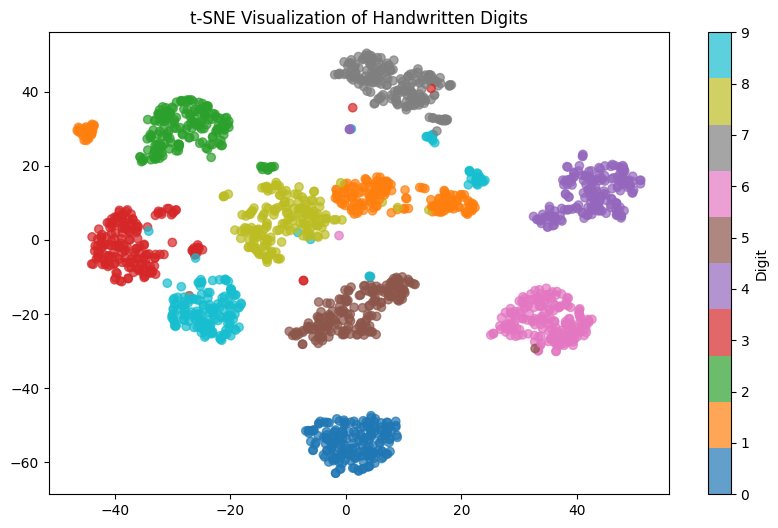

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Digit")
plt.title("t-SNE Visualization of Handwritten Digits")
plt.show()